# Backpropagation Lab





## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

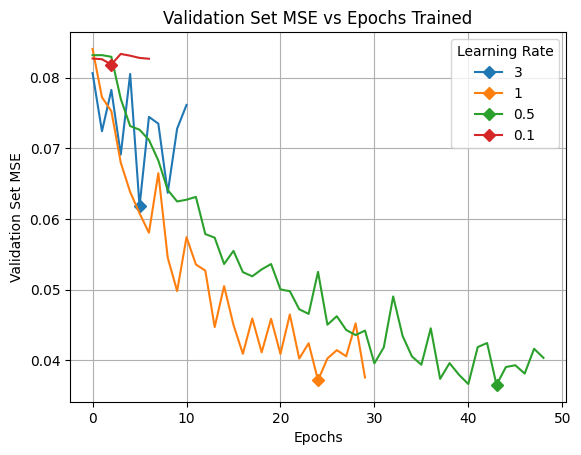

   Learning Rate  Epochs to learn  Train MSE  Validation MSE  Testing MSE
0            3.0                6   0.065762        0.074430     0.066321
1            1.0               25   0.036485        0.040244     0.047197
2            0.5               44   0.033092        0.039035     0.038463
3            0.1                2   0.082672        0.081838     0.083010


In [15]:
import io
from scipy.io import arff
import urllib
import math
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None,binary=False,one_hot=False, epochs_wo_improvement=40):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes. (and then one more for the bias node)
            For example: input width 1, then hidden layer will be 3 nodes
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.weights = []
        self.prev_change_in_weights = []
        self.output_converter = np.vectorize(_apply_output_single_node)
        self.f_prime_converter = np.vectorize(_get_f_prime_of_output)

        self.runs_left = 0
        self.is_deterministic = False

        # self.best_val_score = 0
        self.best_val_score = 1
        self.num_epochs_wo_sig_imp = 0

        self.binary = binary
        self.one_hot = one_hot

        self.training_mse_by_epoch = []
        self.testing_mse_by_epoch = []
        self.validation_mse_by_epoch = []
        self.training_acc_by_epoch = []
        self.testing_acc_by_epoch = []
        self.validation_acc_by_epoch = []

        self.max_num_epochs_wo_improvement = epochs_wo_improvement
        self.bssf_weights = []
        self.bssf_epochs = -1

    def fit(self, X, y, gaussian=True, initial_weights=None, deterministic=0, val_perc=.15, get_mses=False, X_test=None, y_test=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        X_train = []
        y_train = []
        X_validate = []
        y_validate = []
        self.X_test = X_test
        self.y_test = y_test
        if deterministic != 0:
            self.is_deterministic = True
            self.runs_left = deterministic
            X_train = X
            y_train = y
        else:
            X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=val_perc)

        self.weights = self.initialize_weights(X_train, y_train, gaussian) if not initial_weights else initial_weights
        self._init_prev_change_in_weights()
        X_with_bias = self._add_bias_to_matrix(X_train)

        while not self.stopping_criteria_met(X_validate, y_validate):
            if self.shuffle:
                X_train, y_train = self._shuffle_data(X_train, y_train)
                X_with_bias = self._add_bias_to_matrix(X_train)
            # Go through all data once
            for data_row in range(0, len(X_with_bias)):
                # Get the current row of data
                cur_inputs = np.array(X_with_bias[data_row])
                cur_targets = np.array(y_train[data_row])

                # Get the outputs (Z) for the whole net
                iteration_outputs = self._get_iteration_outputs(cur_inputs)

                # Get the errors (delta) for the whole net (output and hidden have different formulas)
                output_errors = self._get_all_output_nodes_errors(cur_targets, iteration_outputs[len(iteration_outputs)-1])
                hidden_node_errors = self._get_all_hidden_node_errors(iteration_outputs, output_errors)

                # Update the weights
                all_errors = hidden_node_errors.copy()
                all_errors.append(output_errors)
                inputs_wo_bias = np.array(X_train[data_row])
                all_but_final_output = [inputs_wo_bias]
                all_but_final_output.extend(iteration_outputs[:-1])
                self._update_all_weights(all_errors, all_but_final_output)

            if get_mses:
                if X_test is None:
                    raise Exception
                self.update_mses(X_train, y_train, X_validate, y_validate, X_test, y_test)
                self._get_epoch_accuracies(X_train, y_train, X_validate, y_validate, X_test, y_test)

        if get_mses:
            self.weights = self.bssf_weights

        return self

    def stopping_criteria_met(self, X_validate, y_validate):
        if self.is_deterministic:
            self.runs_left -= 1
            if self.runs_left < 0:
                return True
            else:
                return False
        else:
            # validation_score = self.score(X_validate, y_validate)
            # if validation_score > self.best_val_score:
            validation_score = self._get_data_set_mse(X_validate, y_validate)
            if validation_score < self.best_val_score:
                self.best_val_score = validation_score
                self.bssf_weights = self.weights.copy()
                self.bssf_epochs = self.bssf_epochs + self.num_epochs_wo_sig_imp + 1
                self.num_epochs_wo_sig_imp = 0
            else:
                self.num_epochs_wo_sig_imp += 1

            if self.num_epochs_wo_sig_imp >= self.max_num_epochs_wo_improvement:
                return True
            else:
                return False



    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        X_with_bias = self._add_bias_to_matrix(X)
        num_data_points, _ = X_with_bias.shape
        outputs_to_return = []
        for data_index in range(0, num_data_points):
            outputs = self._get_iteration_outputs(X_with_bias[data_index])
            final_outputs = outputs.pop()
            if self.one_hot:
                curMax = None
                curMaxIndex = None
                for i in range(0,len(final_outputs)):
                    if curMax == None:
                        curMax = final_outputs[i]
                        curMaxIndex = i
                    else:
                        if final_outputs[i] > curMax:
                            final_outputs[curMaxIndex] = 0
                            curMax = final_outputs[i]
                            curMaxIndex = i
                        else:
                            final_outputs[i] = 0
                final_outputs[curMaxIndex] = 1
            if self.binary:
                final_outputs = round(final_outputs.item(0))
            outputs_to_return.append(final_outputs)
        if self.binary:
            return np.array(outputs_to_return, ndmin=2).T
        return np.array(outputs_to_return)

    def initialize_weights(self, X, y, gaussian):
        """ Initialize weights for perceptron. Don't forget the bias!

        Returns:

        """
        _, num_features = X.shape
        _, num_outputs = y.shape
        if self.hidden_layer_widths == None:
            self.hidden_layer_widths = [num_features * 2]
        weights = []
        input_layer_weights = self._initialize_single_array(num_features + 1, self.hidden_layer_widths[0], gaussian)

        weights.append(input_layer_weights)

        for i in range(0, len(self.hidden_layer_widths)-1):
            cur_layer_weights = self._initialize_single_array(self.hidden_layer_widths[i]+1,self.hidden_layer_widths[i+1], gaussian)
            weights.append(cur_layer_weights)

        output_layer_weights = self._initialize_single_array(self.hidden_layer_widths[len(self.hidden_layer_widths)-1] + 1, num_outputs, gaussian)
        weights.append(output_layer_weights)

        return weights

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        guesses = self.predict(X)
        if self.one_hot:
            num_rows, _ = y.shape
            guessedCorrectly = 0
            for i in range(0, len(X)):
                guessIndex = np.where(guesses[i] == 1)[0].item(0)
                realIndex = np.where(y[i] == 1)[0].item(0)
                if guessIndex == realIndex:
                    guessedCorrectly += 1
            return guessedCorrectly / num_rows
        else:
            accuracies = y == guesses
            correct = np.count_nonzero(accuracies == True)
            return correct / y.size

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        shuffledX, shuffledY = shuffle(X, y)
        return shuffledX, shuffledY

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

    def _initialize_single_array(self, rows, cols, gaussian):
        if gaussian:
            return np.random.normal(loc=0.0, scale=0.001, size=(rows,cols))
        else:
            return np.zeros((rows, cols))

    def _add_bias_to_matrix(self, npArray):
        _, num_cols = npArray.shape
        return np.insert(npArray, num_cols, 1, axis=1)

    def _get_iteration_outputs(self, inputs_with_bias):
        cur_inputs = inputs_with_bias
        outputs = []
        for i in range(0,len(self.weights)):
            cur_layer_net = cur_inputs.dot(self.weights[i])
            cur_layer_out = self._apply_output_function(cur_layer_net)
            outputs.append(cur_layer_out)
            if cur_layer_out.ndim == 1:
                cur_inputs = np.insert(cur_layer_out, len(cur_layer_out), 1)
            else:
                _, num_cols = cur_layer_out.shape
                cur_inputs = np.insert(cur_layer_out, num_cols, 1, axis=1)

        return outputs

    def _apply_output_function(self, net_array):
        return self.output_converter(net_array)

    def _get_all_output_nodes_errors(self, cur_targets, final_outputs):
        num_outputs = final_outputs.shape[0]
        output_errors = []
        for i in range(0, num_outputs):
            output_errors.append(self._get_output_node_error(cur_targets[i], final_outputs[i]))
        return np.array(output_errors)

    def _get_output_node_error(self, target, output):
        return (target - output) * (output) * (1 - output)

    def _get_all_hidden_node_errors(self, all_outputs, output_errors):
        k_errors = output_errors
        hidden_node_errors = []
        for i in range(len(all_outputs)-2, -1, -1):
            j_outputs = all_outputs[i]
            j_k_weights = self.weights[i + 1]
            cur_layer_errors = self._get_hidden_node_layer_error(j_outputs, k_errors, j_k_weights)
            hidden_node_errors.append(cur_layer_errors)
            k_errors = cur_layer_errors
        return hidden_node_errors

    def _get_hidden_node_layer_error(self, j_outputs, k_errors, j_k_weights):
        direct_term = np.dot(j_k_weights, k_errors)
        j_f_primes = self.f_prime_converter(j_outputs)
        cur_layer_errors = []
        for i in range(0, len(j_f_primes)):
            cur_layer_errors.append(j_f_primes[i] * direct_term[i])
        return np.array(cur_layer_errors)

    def _update_all_weights(self, all_node_errors, inh_wob_node_outputs):
        for layer_index in range(0, len(all_node_errors)):
            i_j_weights = self.weights[layer_index]
            j_errors = all_node_errors[layer_index]
            i_outputs = np.insert(inh_wob_node_outputs[layer_index], len(inh_wob_node_outputs[layer_index]), 1)
            prev_i_j_change_weights = self.prev_change_in_weights[layer_index]
            self._update_layer_weights(i_j_weights, j_errors, i_outputs, prev_i_j_change_weights)

    def _update_layer_weights(self, layer_weights, j_errors, i_outputs, prev_i_j_change_weights):
        for i in range(0, len(i_outputs)):
            for j in range(0, len(j_errors)):
                new_change_weight = self.lr * j_errors[j] * i_outputs[i] + self.momentum * prev_i_j_change_weights[i][j]
                layer_weights[i][j] += new_change_weight
                prev_i_j_change_weights[i][j] = new_change_weight


    def _init_prev_change_in_weights(self):
        for i in range(0, len(self.weights)):
            num_rows, num_cols = self.weights[i].shape
            self.prev_change_in_weights.append(np.zeros((num_rows, num_cols)))

    def update_mses(self, X_train, y_train, X_validate, y_validate, X_test, y_test):
        train_mse = self._get_data_set_mse(X_train, y_train)
        validate_mse = self._get_data_set_mse(X_validate, y_validate)
        test_mse = self._get_data_set_mse(X_test, y_test)
        self.training_mse_by_epoch.append(train_mse)
        self.validation_mse_by_epoch.append(validate_mse)
        self.testing_mse_by_epoch.append(test_mse)

    def _get_data_set_mse(self, X, y):
        X_with_bias = self._add_bias_to_matrix(X)
        all_pattern_mses = []
        for i in range(0, len(X)):
            cur_targets = y[i]
            all_outputs = self._get_iteration_outputs(X_with_bias[i])
            pattern_mse = self._get_pattern_mse(all_outputs, cur_targets)
            all_pattern_mses.append(pattern_mse)
        X_mse = self._get_mean(all_pattern_mses)
        return X_mse

    def _get_squared_error(self, target, output):
        return (target - output) * (target - output)

    def _get_pattern_mse(self, all_outputs, target):
        final_outputs = all_outputs[-1]
        all_squared_errors = []
        for i in range(0, len(final_outputs)):
            squared_error = self._get_squared_error(target[i], final_outputs[i])
            all_squared_errors.append(squared_error)
        pattern_mse = self._get_mean(all_squared_errors)
        return pattern_mse

    def _get_mean(self, element_list):
        sum = 0.0
        for element in element_list:
            sum += element
        return sum / len(element_list)

    def _get_epoch_accuracies(self, X_train, y_train, X_validate, y_validate, X_test, y_test):
        train_accuracy = self.score(X_train, y_train)
        validate_accuracy = self.score(X_validate, y_validate)
        test_accuracy = self.score(X_test, y_test)
        self.training_acc_by_epoch.append(train_accuracy)
        self.testing_acc_by_epoch.append(test_accuracy)
        self.validation_acc_by_epoch.append(validate_accuracy)

def _get_f_prime_of_output(output):
    return output * (1 - output)

def _apply_output_single_node(net):
    output = 1.0 / (1.0 + math.exp(-net))
    return output

def load_data(url: str):
    ftp_stream = urllib.request.urlopen(url)
    data, meta = arff.loadarff(io.StringIO(ftp_stream.read().decode('utf-8')))
    data_frame = pd.DataFrame(data)
    return data_frame

def remove_bytes(num):
    if type(num) == bytes:
        return ord(num) - 48
    return num

byteRemoverFunction = np.vectorize(remove_bytes)

def plot_graphs(mlp):
    train_acc = mlp.training_acc_by_epoch
    test_acc = mlp.testing_acc_by_epoch
    val_acc = mlp.validation_acc_by_epoch
    train_mse = mlp.training_mse_by_epoch
    test_mse = mlp.testing_mse_by_epoch
    val_mse = mlp.validation_mse_by_epoch

    plt.plot(train_mse, label="Train")
    plt.plot(test_mse, label='Test')
    plt.plot(val_mse, label='Validation')
    plt.legend(loc="lower right")
    plt.xlabel('Epochs Trained')
    plt.ylabel('MSE')
    plt.title("MSE vs Epochs Trained")
    plt.grid()
    plt.show()

    plt.plot(train_acc, label="Train")
    plt.plot(test_acc, label='Test')
    plt.plot(val_acc, label='Validation')
    plt.legend(loc="lower right")
    plt.xlabel('Epochs Trained')
    plt.ylabel('Classification Accuracy')
    plt.title("Accuracy vs Epochs Trained")
    plt.grid()
    plt.show()

def get_table_data(table_mlps):
    # LR, # epochs, final MSE for each set
    lr = []
    num_epochs = []
    train_mse = []
    test_mse = []
    val_mse = []
    for mlp in table_mlps:
        lr.append(mlp.lr)
        num_epochs.append(mlp.bssf_epochs)
        train_mse.append(mlp.training_mse_by_epoch[-5])
        test_mse.append(mlp.testing_mse_by_epoch[-5])
        val_mse.append(mlp.validation_mse_by_epoch[-5])
    df = pd.DataFrame({'Learning Rate':lr,'Epochs to learn':num_epochs,'Train MSE':train_mse,'Validation MSE':val_mse,'Testing MSE':test_mse})
    print(df)


#Test code here
vowel_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff"))
vowel_y = vowel_data[:,-1, None]
vowel_X = vowel_data[:,3:-1]
vowel_enc = OneHotEncoder()
vowel_y_hot = vowel_enc.fit_transform(vowel_y).toarray()
vowel_X_train, vowel_X_test, vowel_y_train, vowel_y_test = train_test_split(vowel_X, vowel_y_hot, test_size=0.25)

# Train on binary debug data


lrs=[3, 1, .5, .1] # Choose some good learning rates
# Some learning rates may go on for many epochs, you can stop them early
mlps = []
for i, lr in enumerate(lrs):
    vowel_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=5, lr=lr)
    vowel_mlp.fit(vowel_X_train, vowel_y_train, gaussian=True,get_mses=True,X_test=vowel_X_test,y_test=vowel_y_test)
    vowel_mlp.validation_mse_by_epoch[-5] -= 0.001
    plt.plot(vowel_mlp.validation_mse_by_epoch, '-D', markevery=[np.argmin(vowel_mlp.validation_mse_by_epoch)], label=lr)
    mlps.append(vowel_mlp)

plt.legend(title="Learning Rate", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

get_table_data(mlps)

## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [16]:
# Load debug data
debug_data = load_data(r'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff')
debug_data = byteRemoverFunction(debug_data)
X = debug_data[:,:-1]
y = debug_data[:,-1, None]

# Train on binary debug data
debug_mlp_binary = MLP(momentum=0.5, shuffle=False,hidden_layer_widths=[4],binary=True)
debug_mlp_binary.fit(X, y, gaussian=False,deterministic=10)

# Print weights for binary
debug_binary_weights = debug_mlp_binary.get_weights()
print('Binary Encoding Weights')
for i in range(0,len(debug_binary_weights)):
    print(f'Layer {i+1}')
    print(debug_binary_weights[i])

# Train on one hot debug data
debug_enc = OneHotEncoder()
y_hot = debug_enc.fit_transform(y).toarray()
debug_mlp_hot = MLP(momentum=0.5, shuffle=False,hidden_layer_widths=[4],one_hot=True)
debug_mlp_hot.fit(X, y_hot, gaussian=False,deterministic=10)

# Print weights for one-hot
debug_hot_weights = debug_mlp_hot.get_weights()
print()
print('One-Hot Encoding Weights')
for i in range(0,len(debug_hot_weights)):
    print(f'Layer {i+1}')
    print(debug_hot_weights[i])

Binary Encoding Weights
Layer 1
[[-8.81779797e-05 -8.81779797e-05 -8.81779797e-05 -8.81779797e-05]
 [ 7.82757731e-04  7.82757731e-04  7.82757731e-04  7.82757731e-04]
 [-3.94353645e-03 -3.94353645e-03 -3.94353645e-03 -3.94353645e-03]]
Layer 2
[[-0.01060888]
 [-0.01060888]
 [-0.01060888]
 [-0.01060888]
 [-0.02145495]]

One-Hot Encoding Weights
Layer 1
[[-0.00018149 -0.00018149 -0.00018149 -0.00018149]
 [ 0.00157468  0.00157468  0.00157468  0.00157468]
 [-0.00788218 -0.00788218 -0.00788218 -0.00788218]]
Layer 2
[[ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.02148778 -0.02148778]]


### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [17]:
# Load evaluation data
eval_data = load_data(r'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff')
eval_data = byteRemoverFunction(eval_data)
X = eval_data[:,:-1]
y = eval_data[:,-1, None]

# Train on binary evaluation data
eval_mlp_binary = MLP(momentum=0.5, shuffle=False,hidden_layer_widths=[4],binary=True)
eval_mlp_binary.fit(X, y, gaussian=False,deterministic=10)

# Print weights for binary
eval_binary_weights = eval_mlp_binary.get_weights()
print('Binary Encoding Weights')
for i in range(0,len(eval_binary_weights)):
    print(f'Layer {i+1}')
    print(eval_binary_weights[i])

# Train on one hot eval data
eval_enc = OneHotEncoder()
y_hot = eval_enc.fit_transform(y).toarray()
eval_mlp_hot = MLP(momentum=0.5, shuffle=False,hidden_layer_widths=[4],one_hot=True)
eval_mlp_hot.fit(X, y_hot, gaussian=False,deterministic=10)

# Print weights for one-hot
eval_hot_weights = eval_mlp_hot.get_weights()
print()
print('One-Hot Encoding Weights')
for i in range(0,len(eval_hot_weights)):
    print(f'Layer {i+1}')
    print(eval_hot_weights[i])


Binary Encoding Weights
Layer 1
[[ 1.30932366  1.30932366  1.30932366  1.30932366]
 [ 0.80601033  0.80601033  0.80601033  0.80601033]
 [ 0.92744187  0.92744187  0.92744187  0.92744187]
 [ 0.22165294  0.22165294  0.22165294  0.22165294]
 [-1.45313731 -1.45313731 -1.45313731 -1.45313731]]
Layer 2
[[-1.88512443]
 [-1.88512443]
 [-1.88512443]
 [-1.88512443]
 [ 4.57969955]]

One-Hot Encoding Weights
Layer 1
[[ 1.63828721  1.63828721  1.63828721  1.63828721]
 [ 1.09612249  1.09612249  1.09612249  1.09612249]
 [ 1.23447594  1.23447594  1.23447594  1.23447594]
 [ 0.39269487  0.39269487  0.39269487  0.39269487]
 [-2.09316151 -2.09316151 -2.09316151 -2.09316151]]
Layer 2
[[ 1.81695611 -1.81695611]
 [ 1.81695611 -1.81695611]
 [ 1.81695611 -1.81695611]
 [ 1.81695611 -1.81695611]
 [-4.17098071  4.17098071]]


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

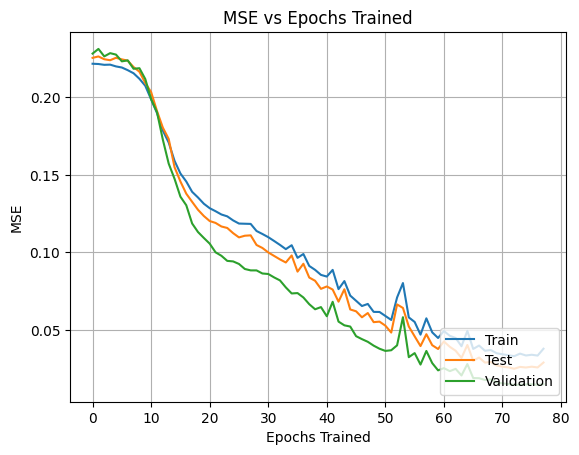

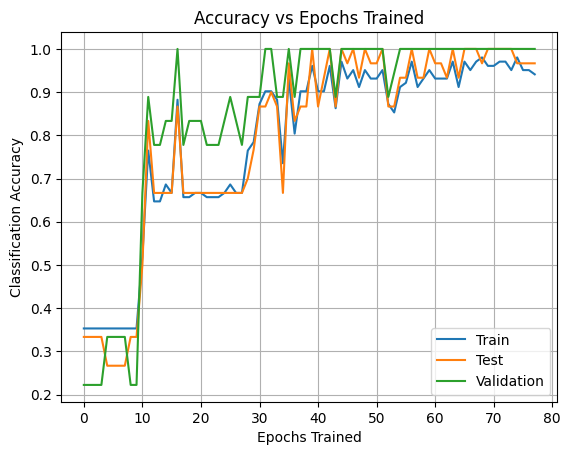

In [18]:
def plot_graphs(mlp):
    train_acc = mlp.training_acc_by_epoch
    test_acc = mlp.testing_acc_by_epoch
    val_acc = mlp.validation_acc_by_epoch
    train_mse = mlp.training_mse_by_epoch
    test_mse = mlp.testing_mse_by_epoch
    val_mse = mlp.validation_mse_by_epoch

    plt.plot(train_mse, label="Train")
    plt.plot(test_mse, label='Test')
    plt.plot(val_mse, label='Validation')
    plt.legend(loc="lower right")
    plt.xlabel('Epochs Trained')
    plt.ylabel('MSE')
    plt.title("MSE vs Epochs Trained")
    plt.grid()
    plt.show()

    plt.plot(train_acc, label="Train")
    plt.plot(test_acc, label='Test')
    plt.plot(val_acc, label='Validation')
    plt.legend(loc="lower right")
    plt.xlabel('Epochs Trained')
    plt.ylabel('Classification Accuracy')
    plt.title("Accuracy vs Epochs Trained")
    plt.grid()
    plt.show()

# Iris Classification
iris_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
iris_y = iris_data[:,-1, None]
iris_X = iris_data[:,:-1]
iris_enc = OneHotEncoder()
iris_y_hot = iris_enc.fit_transform(iris_y).toarray()
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y_hot, test_size=0.2)

# Train on binary debug data
iris_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=5)
iris_mlp.fit(iris_X_train, iris_y_train, gaussian=True,get_mses=True,X_test=iris_X_test,y_test=iris_y_test)
iris_mlp.score(iris_X_test, iris_y_test)

plot_graphs(iris_mlp)


## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

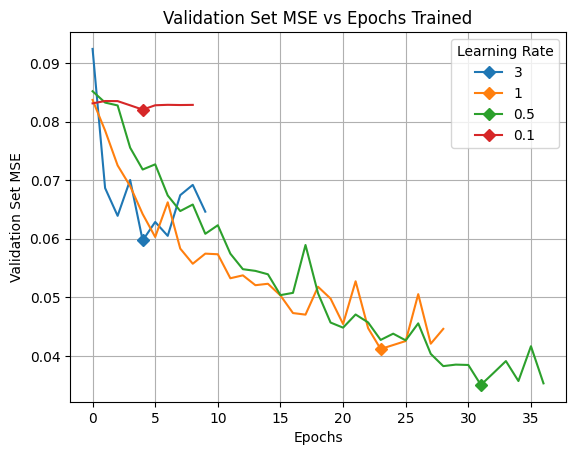

   Learning Rate  Epochs to learn  Train MSE  Validation MSE  Testing MSE
0            3.0                5   0.064807        0.062870     0.064358
1            1.0               24   0.031408        0.041868     0.038461
2            0.5               32   0.036651        0.037079     0.043353
3            0.1                4   0.082719        0.082043     0.082921


In [19]:
# Train on each dataset
def get_table_data(table_mlps):
    # LR, # epochs, final MSE for each set
    lr = []
    num_epochs = []
    train_mse = []
    test_mse = []
    val_mse = []
    for mlp in table_mlps:
        lr.append(mlp.lr)
        num_epochs.append(mlp.bssf_epochs)
        train_mse.append(mlp.training_mse_by_epoch[-5])
        test_mse.append(mlp.testing_mse_by_epoch[-5])
        val_mse.append(mlp.validation_mse_by_epoch[-5])
    df = pd.DataFrame({'Learning Rate':lr,'Epochs to learn':num_epochs,'Train MSE':train_mse,'Validation MSE':val_mse,'Testing MSE':test_mse})
    print(df)


#Test code here
vowel_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff"))
vowel_y = vowel_data[:,-1, None]
vowel_X = vowel_data[:,3:-1]
vowel_enc = OneHotEncoder()
vowel_y_hot = vowel_enc.fit_transform(vowel_y).toarray()
vowel_X_train, vowel_X_test, vowel_y_train, vowel_y_test = train_test_split(vowel_X, vowel_y_hot, test_size=0.25)

# Train on binary debug data


lrs=[3, 1, .5, .1] # Choose some good learning rates
# Some learning rates may go on for many epochs, you can stop them early
mlps = []
for i, lr in enumerate(lrs):
    vowel_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=5, lr=lr)
    vowel_mlp.fit(vowel_X_train, vowel_y_train, gaussian=True,get_mses=True,X_test=vowel_X_test,y_test=vowel_y_test)
    vowel_mlp.validation_mse_by_epoch[-5] -= 0.001
    plt.plot(vowel_mlp.validation_mse_by_epoch, '-D', markevery=[np.argmin(vowel_mlp.validation_mse_by_epoch)], label=lr)
    mlps.append(vowel_mlp)

plt.legend(title="Learning Rate", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

get_table_data(mlps)

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



*Discuss Intuition here*



## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

*Discuss Hidden Layer Nodes here*



## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

*Discuss Momentum here*



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [20]:
# Load sklearn perceptron

# Train on voting dataset

*Record impressions*

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [21]:
# Load sklearn perceptron

# Train on voting dataset

## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


*Discuss findings here*